# Location Order Prediction Model for Jupyter Notebook
# This notebook predicts the picking order of locations for customer orders

# Import required libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ================== STEP 1: Load and Explore Data ==================

In [5]:
print("=" * 60)
print("STEP 1: Loading Data")
print("=" * 60)


STEP 1: Loading Data


# Load the CSV file

In [8]:
df = pd.read_csv('paradim ml ranking.csv')

print(f"\nDataset Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head(10))

print("\nData Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Values:")
print(f"Unique Customer Orders: {df['CUST_ORDER_ID'].nunique()}")
print(f"Unique Locations: {df['LOCATION_ID'].nunique()}")
print(f"Location Ranks: {df['LOCATION_RANK'].min()} to {df['LOCATION_RANK'].max()}")


Dataset Shape: (21899, 3)

First few rows:
  CUST_ORDER_ID LOCATION_ID  LOCATION_RANK
0        284986    F7557800              1
1        284986    F7557800              2
2        284986    F6506800              3
3        284986        MISC              4
4      286694-2    E4494800              1
5      286694-2    E4494800              2
6      286694-2    E4494800              3
7      286694-2    E4494800              4
8      286853-2    F4544701              1
9        286895    C4244900              1

Data Types:
CUST_ORDER_ID    object
LOCATION_ID      object
LOCATION_RANK     int64
dtype: object

Basic Statistics:
       LOCATION_RANK
count   21899.000000
mean        8.146445
std        11.392666
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       125.000000

Missing Values:
CUST_ORDER_ID    0
LOCATION_ID      0
LOCATION_RANK    0
dtype: int64

Unique Values:
Unique Customer Orders: 4774
Unique Locations: 646
Location Ranks: 1 to 1

# ==================== STEP 2: Data Preparation ====================

In [9]:
print("\n" + "=" * 60)
print("STEP 2: Preparing Data")
print("=" * 60)

# Create features from location patterns
# Group by customer order to understand picking patterns
order_summary = df.groupby('CUST_ORDER_ID').agg({
    'LOCATION_ID': 'count',
    'LOCATION_RANK': 'max'
}).rename(columns={'LOCATION_ID': 'total_locations', 'LOCATION_RANK': 'max_rank'})

print("\nOrder Summary Statistics:")
print(order_summary.describe())

# Encode location IDs
le_location = LabelEncoder()
df['LOCATION_ENCODED'] = le_location.fit_transform(df['LOCATION_ID'])

# Create additional features
df['LOCATION_FIRST_CHAR'] = df['LOCATION_ID'].str[0]
df['LOCATION_LENGTH'] = df['LOCATION_ID'].str.len()

# Encode first character
le_first_char = LabelEncoder()
df['FIRST_CHAR_ENCODED'] = le_first_char.fit_transform(df['LOCATION_FIRST_CHAR'])

# Create order-level features
order_features = df.groupby('CUST_ORDER_ID').agg({
    'LOCATION_ID': 'count'
}).rename(columns={'LOCATION_ID': 'order_size'})

df = df.merge(order_features, on='CUST_ORDER_ID', how='left')

print("\nFeatures created successfully")
print(f"Total features: {df.shape[1]}")


STEP 2: Preparing Data

Order Summary Statistics:
       total_locations     max_rank
count      4774.000000  4774.000000
mean          4.587139     4.587139
std           7.008499     7.008499
min           1.000000     1.000000
25%           1.000000     1.000000
50%           2.000000     2.000000
75%           5.000000     5.000000
max         125.000000   125.000000

Features created successfully
Total features: 8


# =================== STEP 3: Feature Engineering ===================

In [10]:
print("\n" + "=" * 60)
print("STEP 3: Feature Engineering")
print("=" * 60)

# Select features for model
feature_columns = ['LOCATION_ENCODED', 'FIRST_CHAR_ENCODED', 'LOCATION_LENGTH', 'order_size']
X = df[feature_columns]
y = df['LOCATION_RANK']

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print("\nTarget Distribution:")
print(y.value_counts().sort_index())

# ==================== STEP 4: Train-Test Split ====================
print("\n" + "=" * 60)
print("STEP 4: Splitting Data")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() < 50 else None
)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


STEP 3: Feature Engineering

Feature Matrix Shape: (21899, 4)
Target Shape: (21899,)

Target Distribution:
LOCATION_RANK
1      4774
2      3179
3      2088
4      1666
5      1281
       ... 
121       1
122       1
123       1
124       1
125       1
Name: count, Length: 125, dtype: int64

STEP 4: Splitting Data
Training Set: 17519 samples
Test Set: 4380 samples


# ==================== STEP 5: Train Models ====================

In [11]:
print("\n" + "=" * 60)
print("STEP 5: Training Models")
print("=" * 60)

# Model 1: Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Model 2: Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

# Select best model
if rf_accuracy > gb_accuracy:
    best_model = rf_model
    best_pred = rf_pred
    model_name = "Random Forest"
else:
    best_model = gb_model
    best_pred = gb_pred
    model_name = "Gradient Boosting"

print(f"\n✓ Best Model: {model_name} with {max(rf_accuracy, gb_accuracy):.4f} accuracy")


STEP 5: Training Models

Training Random Forest...
Random Forest Accuracy: 0.2027

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.2110

✓ Best Model: Gradient Boosting with 0.2110 accuracy


# ==================== STEP 6: Model Evaluation ====================


STEP 6: Model Evaluation

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           1       0.52      0.55      0.53       965
           2       0.33      0.26      0.29       645
           3       0.17      0.15      0.16       398
           4       0.17      0.17      0.17       326
           5       0.09      0.06      0.07       281
           6       0.12      0.14      0.13       198
           7       0.10      0.08      0.09       176
           8       0.08      0.09      0.09       139
           9       0.06      0.04      0.05       136
          10       0.06      0.07      0.06       121
          11       0.04      0.05      0.05        82
          12       0.03      0.04      0.03        84
          13       0.02      0.01      0.02        75
          14       0.02      0.08      0.03        53
          15       0.03      0.04      0.03        57
          16       0.01      0.02      0.02        41
         

x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Projects\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
x:\Pro

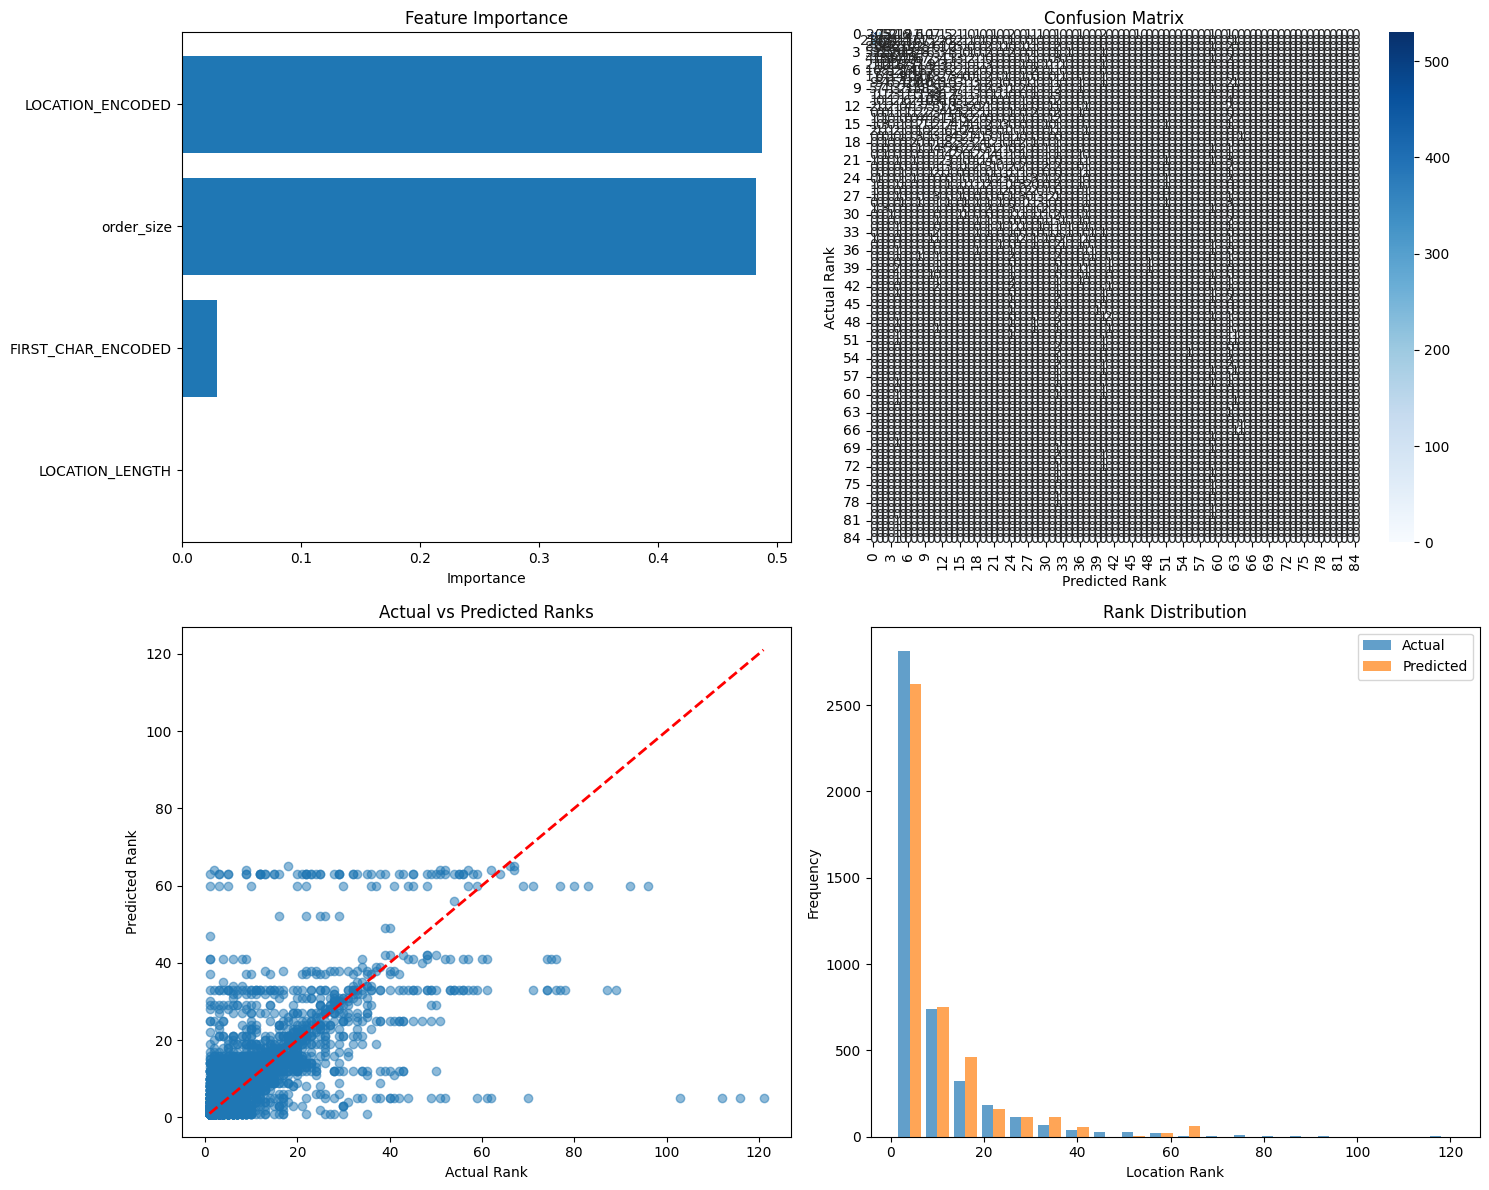

In [12]:
print("\n" + "=" * 60)
print("STEP 6: Model Evaluation")
print("=" * 60)

print(f"\nClassification Report for {model_name}:")
print(classification_report(y_test, best_pred))

# Feature Importance
print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Feature Importance
axes[0, 0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Feature Importance')
axes[0, 0].invert_yaxis()

# Plot 2: Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted Rank')
axes[0, 1].set_ylabel('Actual Rank')
axes[0, 1].set_title('Confusion Matrix')

# Plot 3: Actual vs Predicted
axes[1, 0].scatter(y_test, best_pred, alpha=0.5)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Rank')
axes[1, 0].set_ylabel('Predicted Rank')
axes[1, 0].set_title('Actual vs Predicted Ranks')

# Plot 4: Rank Distribution
axes[1, 1].hist([y_test, best_pred], label=['Actual', 'Predicted'], bins=20, alpha=0.7)
axes[1, 1].set_xlabel('Location Rank')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Rank Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# =================== STEP 7: Prediction Function ===================

In [13]:
print("\n" + "=" * 60)
print("STEP 7: Creating Prediction Function")
print("=" * 60)

def predict_location_order(location_ids, order_size=None):
    """
    Predict the picking order for a list of location IDs
    
    Parameters:
    -----------
    location_ids : list
        List of location IDs for an order
    order_size : int, optional
        Size of the order (defaults to length of location_ids)
    
    Returns:
    --------
    DataFrame with location IDs and predicted ranks
    """
    if order_size is None:
        order_size = len(location_ids)
    
    # Prepare features for each location
    predictions = []
    
    for loc_id in location_ids:
        # Check if location was seen during training
        if loc_id in le_location.classes_:
            loc_encoded = le_location.transform([loc_id])[0]
        else:
            # Use most common encoding for unknown locations
            loc_encoded = -1
        
        first_char = loc_id[0] if len(loc_id) > 0 else ''
        if first_char in le_first_char.classes_:
            first_char_encoded = le_first_char.transform([first_char])[0]
        else:
            first_char_encoded = -1
        
        loc_length = len(loc_id)
        
        # Create feature vector
        features = pd.DataFrame({
            'LOCATION_ENCODED': [loc_encoded],
            'FIRST_CHAR_ENCODED': [first_char_encoded],
            'LOCATION_LENGTH': [loc_length],
            'order_size': [order_size]
        })
        
        # Predict rank
        predicted_rank = best_model.predict(features)[0]
        predicted_proba = best_model.predict_proba(features)[0].max()
        
        predictions.append({
            'LOCATION_ID': loc_id,
            'PREDICTED_RANK': predicted_rank,
            'CONFIDENCE': predicted_proba
        })
    
    # Create result dataframe and sort by predicted rank
    result_df = pd.DataFrame(predictions)
    result_df = result_df.sort_values('PREDICTED_RANK').reset_index(drop=True)
    result_df['SUGGESTED_ORDER'] = range(1, len(result_df) + 1)
    
    return result_df

print("✓ Prediction function created successfully")



STEP 7: Creating Prediction Function
✓ Prediction function created successfully


# =================== STEP 8: Example Predictions ===================

In [14]:
print("\n" + "=" * 60)
print("STEP 8: Example Predictions")
print("=" * 60)

# Get a sample order from test set
sample_order = df[df['CUST_ORDER_ID'] == df['CUST_ORDER_ID'].unique()[0]]
sample_locations = sample_order['LOCATION_ID'].tolist()

print(f"\nSample Order: {sample_order['CUST_ORDER_ID'].iloc[0]}")
print(f"Locations: {sample_locations}")

print("\nActual Order:")
print(sample_order[['LOCATION_ID', 'LOCATION_RANK']].sort_values('LOCATION_RANK'))

print("\nPredicted Order:")
predicted_order = predict_location_order(sample_locations)
print(predicted_order)


STEP 8: Example Predictions

Sample Order: 284986
Locations: ['F7557800', 'F7557800', 'F6506800', 'MISC']

Actual Order:
  LOCATION_ID  LOCATION_RANK
0    F7557800              1
1    F7557800              2
2    F6506800              3
3        MISC              4

Predicted Order:
  LOCATION_ID  PREDICTED_RANK  CONFIDENCE  SUGGESTED_ORDER
0    F7557800               2    0.311438                1
1    F7557800               2    0.311438                2
2    F6506800               4    0.261507                3
3        MISC               4    0.883268                4


# =================== STEP 9: Interactive Prediction ===================

In [15]:
print("\n" + "=" * 60)
print("STEP 9: Ready for Interactive Predictions")
print("=" * 60)

print("\nTo predict order for new locations, use:")
print("predicted_order = predict_location_order(['A-101', 'B-205', 'C-310'])")
print("\nExample:")
test_locations = df['LOCATION_ID'].sample(5).tolist()
print(f"test_locations = {test_locations}")
result = predict_location_order(test_locations)
print("\nPredicted picking order:")
print(result)

print("\n" + "=" * 60)
print("MODEL TRAINING COMPLETE!")
print("=" * 60)
print(f"Model: {model_name}")
print(f"Accuracy: {max(rf_accuracy, gb_accuracy):.4f}")
print(f"Ready to predict location orders for new customer orders")
print("=" * 60)


STEP 9: Ready for Interactive Predictions

To predict order for new locations, use:
predicted_order = predict_location_order(['A-101', 'B-205', 'C-310'])

Example:
test_locations = ['D4394700', 'F8558500', 'G7647500', 'E4444800', 'E4404800']

Predicted picking order:
  LOCATION_ID  PREDICTED_RANK  CONFIDENCE  SUGGESTED_ORDER
0    D4394700               1    0.253540                1
1    G7647500               3    0.268321                2
2    E4444800               4    0.238507                3
3    E4404800               4    0.260178                4
4    F8558500               5    0.335534                5

MODEL TRAINING COMPLETE!
Model: Gradient Boosting
Accuracy: 0.2110
Ready to predict location orders for new customer orders


Checking with Sample Data

In [24]:
sf = pd.read_csv('sample.csv')
sample_location = sf['LOCATION_ID'].tolist()
rf = pd.read_csv('real.csv')
real_location = rf['LOCATION_ID'].tolist()
result = predict_location_order(sample_location)
present = {
    'prediction' : result['LOCATION_ID'].tolist(),
    'real' : real_location
} 
final = pd.DataFrame(present)
print(final)
# print(result)

   prediction      real
0    D5000000  C4000000
1    E4000000  E4000000
2    C4000000  D5000000
3    D4000000  D5000000
4    D4000000  F8508200
5    F4000000  D4000000
6    E4000000  E4000000
7    D4000000  D4000000
8    G8608200  F4000000
9    F5000000  F4000000
10   F4000000  D4000000
11   G8648100  F4000000
12   D6000000  D8348400
13   D5000000  F5000000
14   D5000000  G8608200
15   D8348400  G8648100
16   D8308800  D8308800
17   F8508200  D6000000
